# A test of unet model `(2D -> 3D)` on SWIR imagery

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2 

import os
import logging
import sys
sys.path.append("../common/")

from data_utils import TRAIN_LABEL_TILES, TRAIN_DATA, TRAIN_IMAGE_IDS, LABELS
from data_utils import get_resized_polygons, get_filename
from image_utils import get_image_data, generate_label_file
from visu_utils import display_img_1b

In [2]:
logging.getLogger().setLevel(logging.INFO)

In [3]:
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files if 'mean' not in s and 'std' not in s])
print "First train tile : ", all_train_files[0], all_train_files[-1], len(all_train_files)

First train tile :  6010_1_2 6170_4_1 25


In [4]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_files)*0.8)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]

mean_fname = os.path.join(TRAIN_DATA, 'mean_swir_image.tif')
std_fname = os.path.join(TRAIN_DATA, 'std_swir_image.tif')
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_files, 'swir_aligned')
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(std_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_files), len(val_files)

logging.getLogger().setLevel(logging.ERROR)

(134L, 137L, 8L) (134L, 137L, 8L)
261.6 5654.65 788.311 3489.79
20 5


No handlers could be found for logger "geo_utils.GeoImage"


In [5]:
from image_utils import get_image_data, generate_label_image2
from data_utils import TRAIN_WKT, get_image_ids, get_filename

def swir_images_iterator(image_ids_to_use, 
                         classes, 
                         size, 
                         mean_image=None,
                         std_image=None):
    
    
    gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
    random_rotation_angles=(0.0, 5.0, 0.0, -5.0, 0.0, 15.0, 0.0, -15.0)
    
    while True:

        image_ids = get_image_ids(classes, gb)
        image_ids = list(set(image_ids) & set(image_ids_to_use))
        np.random.shuffle(image_ids)
        
        for i, image_id in enumerate(image_ids):
            
            img_swir = get_image_data(image_id, 'swir_aligned').astype(np.float32)
            img_label = generate_label_image2(image_id, 'swir_aligned')            
            img_label = img_label[:, :, classes]    
            
            if mean_image is not None and std_image is not None:
                h, w, _ = img_swir.shape
                img_swir -= mean_image[:h,:w,:]
                img_swir /= (std_image[:h,:w,:] + 0.00001)

            # Add random rotation and scale
            sc = 1.0
            a = random_rotation_angles[np.random.randint(len(random_rotation_angles))] if len(random_rotation_angles) > 0 else 0.0
            if a != 0 and sc < 1.15:
                sc = 1.15
            h, w, _ = img_swir.shape
            warp_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), a, sc)

            img_swir = cv2.warpAffine(img_swir,
                                      warp_matrix,
                                      dsize=(w, h),
                                      flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            img_label = cv2.warpAffine(img_label,
                                      warp_matrix,
                                      dsize=(w, h),
                                      flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            if img_swir.shape[:2] != size[::-1]:                 
                img_swir = cv2.resize(img_swir, dsize=size, interpolation=cv2.INTER_LINEAR)
                img_label = cv2.resize(img_label, dsize=size, interpolation=cv2.INTER_LINEAR)
            
            assert img_swir.shape[:2] == img_label.shape[:2], "Image sizes are not equal: {} != {}".format \
                (img_label.shape[:2], img_swir.shape[:2])
            yield img_swir, img_label

In [6]:
from data_utils import get_image_ids

def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out

def compute_ndvi_like(x, vis_index, nir_index):
    vis = x[:,:,vis_index].astype(np.float32)
    nir = x[:,:,nir_index].astype(np.float32())
    ndvi = (nir - vis) / (nir + vis + 0.00001)
    return ndvi

def generate_ndvi_like_image(img_swir, n_channels, nn=2):
    h, w, nc = img_swir.shape
    out = np.zeros((h,w,n_channels), dtype=np.float32)
    count = 0
    for vis_index in range(nc):
        vals = list(range(nc))
        start = vis_index + nn + 1
        end = vis_index - nn if vis_index - nn > 0 else 0
        v2 = vals[:end]; vals = vals[start:]
        vals.extend(v2)        
        for nir_index in vals:
            out[:,:,count]=compute_ndvi_like(img_swir, vis_index, nir_index)
            count += 1
    return out

def generate_images(image_ids_to_use, batch_size):
    while True:        
        # Input shape should be 5D for Convolution3D        
        X = np.zeros((batch_size, 1, n_channels)+size[::-1], dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+size[::-1], dtype=np.float32)
        images = swir_images_iterator(image_ids_to_use, 
                                     labels, 
                                     size=size, 
                                     mean_image=None,
                                     std_image=None)
        counter = 0
        for x, y in images:     
            
            x = generate_ndvi_like_image(x, n_channels=n_channels)            
            x = normalize_image(x)
            y = normalize_image(y)     

            X[counter,0,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


In [7]:
shape = get_image_data(TRAIN_IMAGE_IDS[0], 'swir_aligned', return_shape_only=True)

size = (136, 136)
# channels = np.array(range(mean_image.shape[2]))
# channels = np.arange(0,8,dtype=np.uint8)
# n_channels = 8
def compute_nb_channels(nc, nn=2):
    count = 0
    for vis_index in range(nc):
        vals = list(range(nc))
        start = vis_index + nn + 1
        end = vis_index - nn if  vis_index - nn > 0 else 0
        v2 = vals[:end]; vals = vals[start:]
        vals.extend(v2)        
        for nir_index in vals:
            count += 1
    return count

n_channels = compute_nb_channels(8)

labels = np.array([5, 6, 8, 7])
n_labels = len(labels)

print size, n_channels, labels

(136, 136) 30 [5 6 8 7]


(5L, 1L, 30L, 136L, 136L) (5L, 4L, 136L, 136L)
-0.741258 0.741258 0.0 1.0


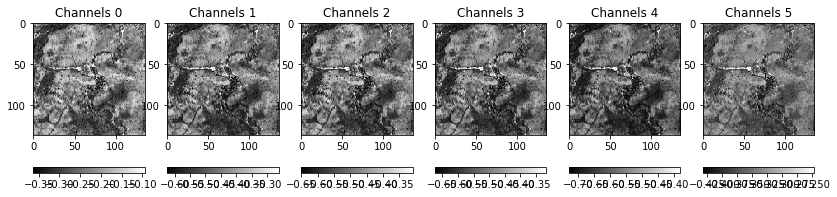

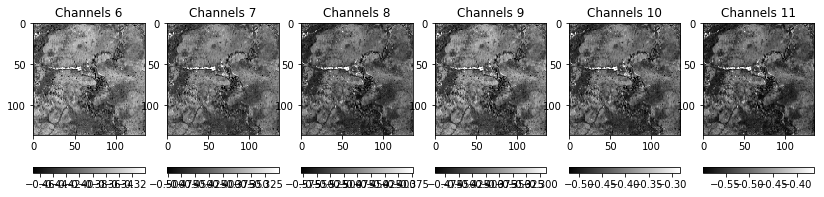

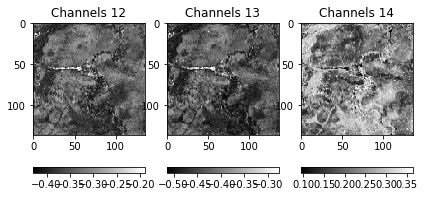

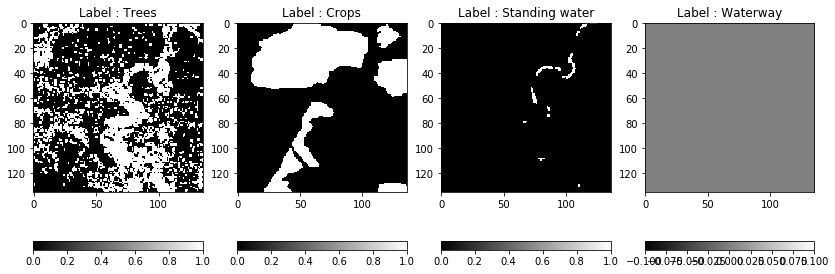

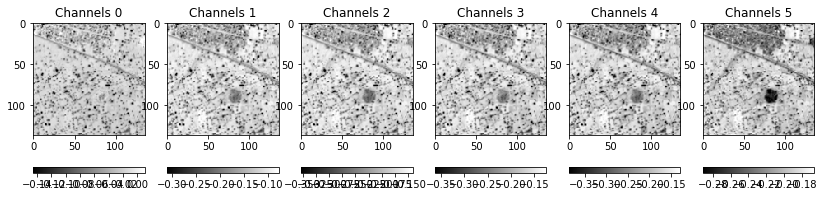

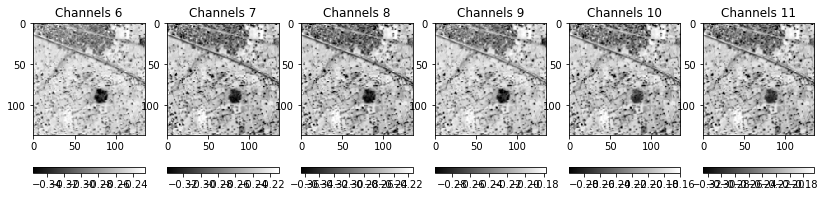

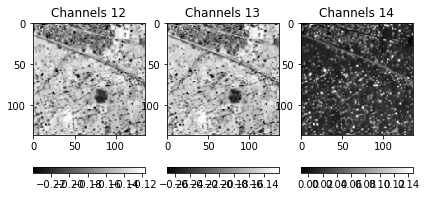

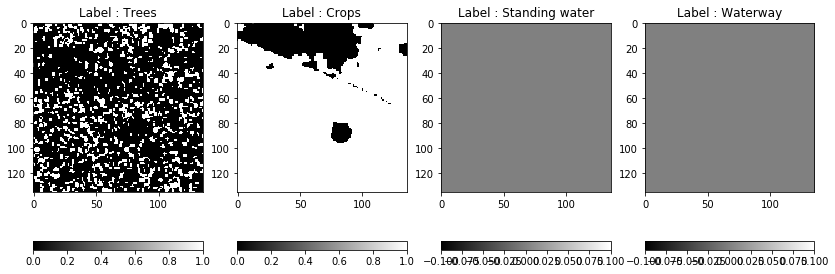

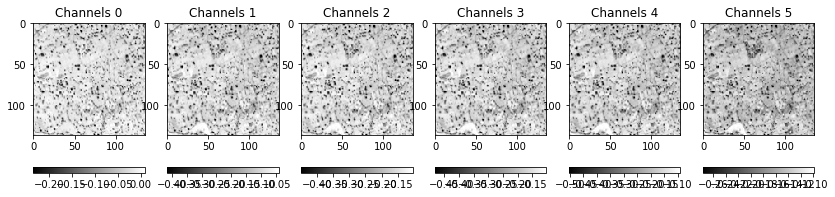

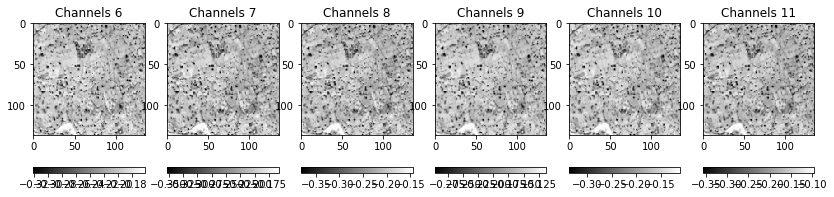

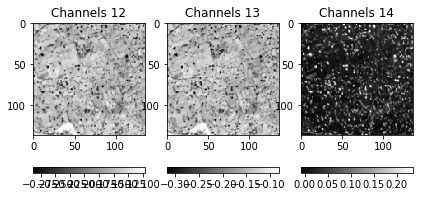

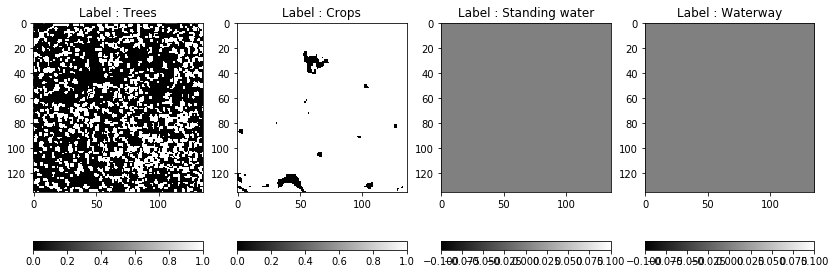

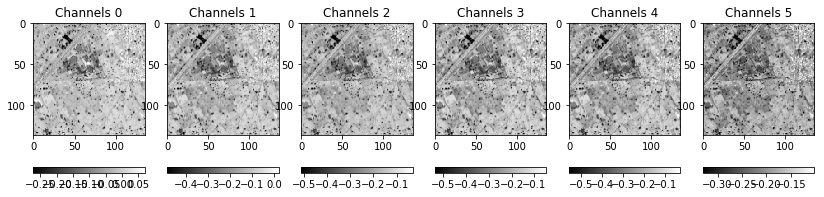

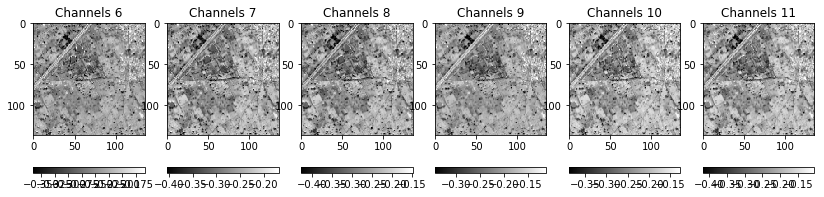

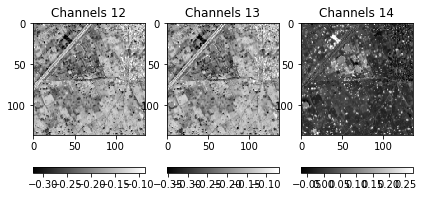

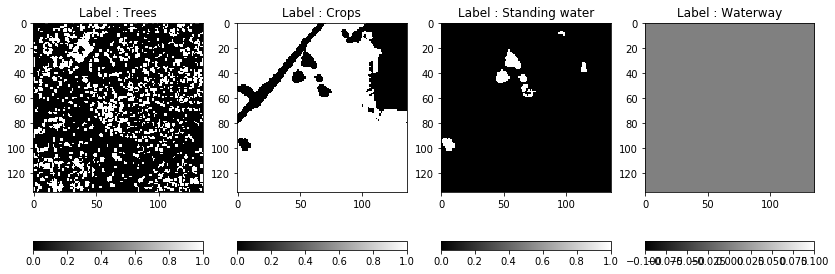

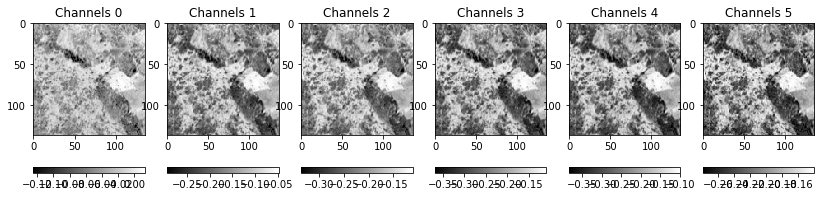

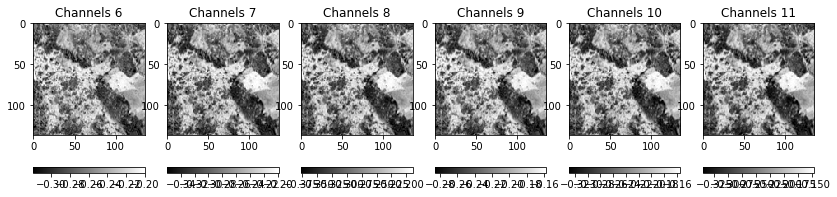

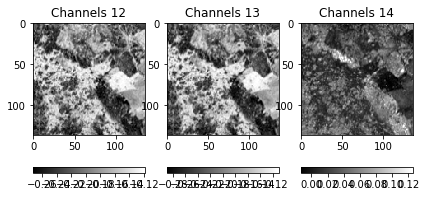

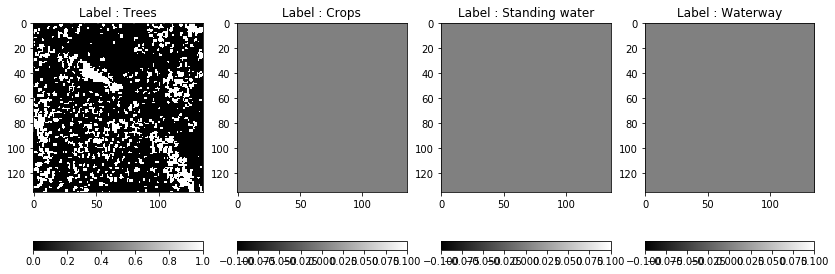

In [8]:
batch_size = 5
for X, Y in generate_images(train_files, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,0,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [9]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from unet_3d import unet_zero

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN 4007)


SyntaxError: EOL while scanning string literal (../common/unet_3d.py, line 29)

In [ ]:
import theano 
import keras.backend as K
theano.config.device, K.image_dim_ordering(), K.backend()

In [76]:
deep=False 
n_filters_0=32

model = unet_zero(n_labels, n_channels, size[0], size[1], deep=deep, n_filters_0=n_filters_0, n_levels=1)

weights_filename = os.path.join("weights", "unet_3d_zero_%i_%i_%s_%i.h5" % (n_channels, n_labels, str(deep), n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

ValueError: "concat" mode can only merge layers with matching output shapes except for the concat axis. Layer shapes: [(None, 128, 16, 68, 68), (None, 64, 15, 68, 68)]

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 56, 136, 13 0                                            
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 32, 56, 136, 1 896         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling3d_1 (MaxPooling3D)    (None, 32, 28, 68, 68 0           convolution3d_1[0][0]            
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 64, 28, 68, 68 55360       maxpooling3d_1[0][0]             
___________________________________________________________________________________________

In [12]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
model.compile(optimizer=Adadelta(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [14]:
batch_size = 1
samples_per_epoch = 32
nb_val_samples = 16

print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_files, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=10,
    validation_data=generate_images(val_files, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

1 32 16
Epoch 1/10


MemoryError: Error allocating 132579328 bytes of device memory (out of memory).
Apply node that caused the error: GpuDnnConv3d{algo='small', inplace=False}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})
Toposort index: 359
Inputs types: [CudaNdarrayType(float32, 5D), CudaNdarrayType(float32, 5D), CudaNdarrayType(float32, 5D), <theano.gof.type.CDataType object at 0x0000000035360908>, Scalar(float32), Scalar(float32)]
Inputs shapes: [(1, 1, 56, 136, 136), (32, 1, 3, 3, 3), (1, 32, 56, 136, 136), 'No shapes', (), ()]
Inputs strides: [(0, 0, 18496, 136, 1), (27, 0, 9, 3, 1), (0, 1035776, 18496, 136, 1), 'No strides', (), ()]
Inputs values: ['not shown', 'not shown', 'not shown', <capsule object NULL at 0x000000004B084960>, 1.0, 0.0]
Inputs name: ('image', 'kernel', 'output', 'descriptor', 'alpha', 'beta')

Outputs clients: [[GpuElemwise{add,no_inplace}(GpuDnnConv3d{algo='small', inplace=False}.0, GpuDimShuffle{x,0,x,x,x}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

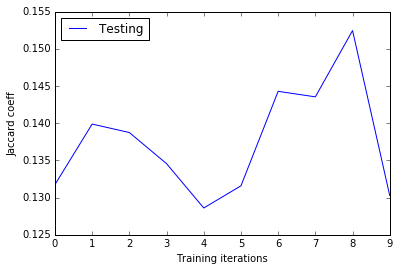

In [127]:
plt.plot(history.history['val_jaccard_coef'])
plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

(5, 4, 136, 136) 0.116623 0.625548


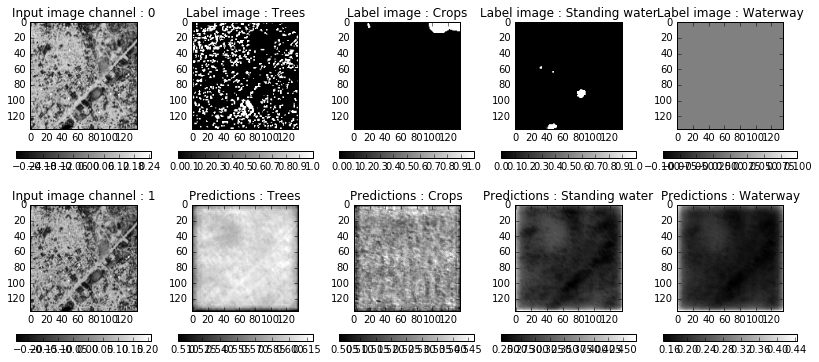

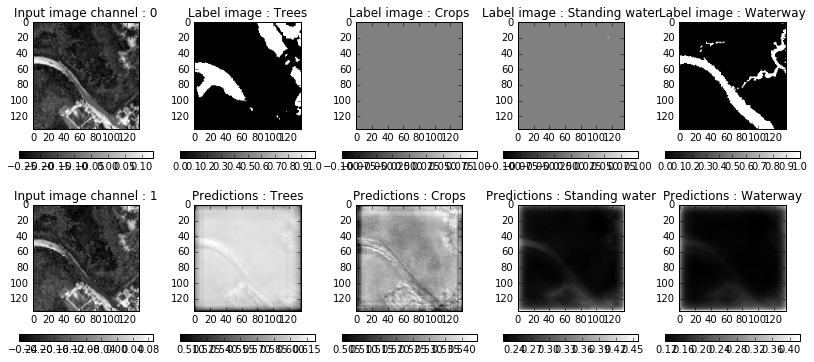

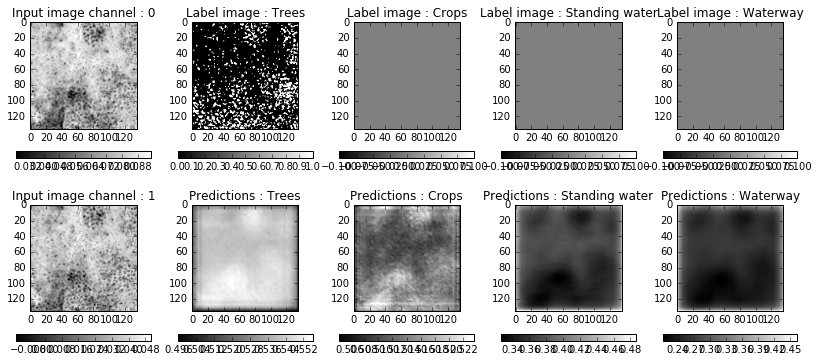

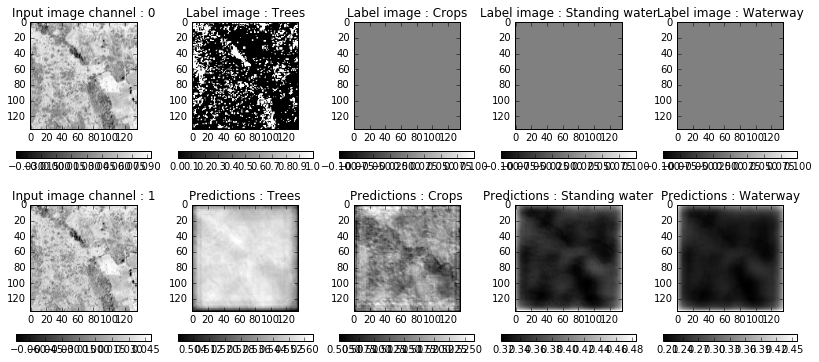

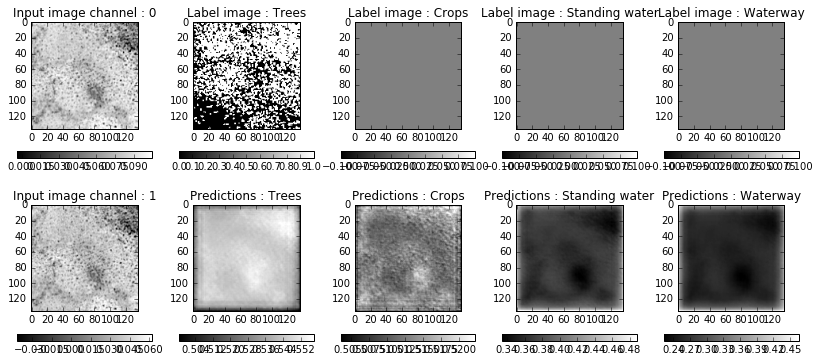

In [135]:
batch_size = 5

for X, Y in generate_images(train_files, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,0,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(np.clip(Y_pred[i,jj,:,:], 0.0, 1.0))
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


In [133]:
from keras import backend as K

In [136]:
jci = jaccard_coef_int(K.variable(Y), K.variable(Y_pred))
jc = jaccard_coef(K.variable(Y), K.variable(Y_pred))
print jci.eval(), jc.eval()

0.123772591352 0.062232375145


View inside

In [29]:
from nn_visu_utils import display_layer_output, compute_layer_outputs

In [ ]:
batch_size = 5
layer_output_f_dict = {}
for X, _ in generate_images(train_files, batch_size):
    
    layer_output_pairs = compute_layer_outputs(X, model, layer_output_f_dict)
    for i in range(batch_size):
        for (layer_name, layer_outputs) in layer_output_pairs:
            plt.figure(figsize=(14, 6))
            display_layer_output(layer_name, layer_outputs[0][i,:,:,:], 16)
        break
    break